In [6]:
%load_ext autoreload

%autoreload 2

In [7]:
import numpy as np

# Steps

- Train loop
    - Forward
        - Conv
        - Relu
        - Conv
        - Relu
        - Dense
        - Softmax
        - Cross entropy
    
    Backprop the gradients for all the layers

    Test the code for MNIST

In [11]:
import mnist

In [12]:
mnist.init()

Download complete.
Save complete.


In [13]:
x_train, y_train, x_test, y_test = mnist.load()

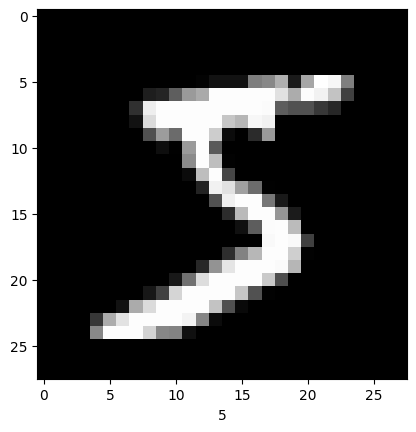

In [14]:
import matplotlib.pyplot as plt

img1 = x_train[0,:].reshape(28,28) # First image in the training set.
plt.imshow(img1,cmap='gray')
plt.xlabel(y_train[0])
plt.show() # Show the image

In [15]:
from layer import Layer

### Relu layer

In [16]:
class ReluLayer(Layer):
    def __init__(self, layer_name):
        super().__init__(layer_name)
        self.cached_output = None

    def forward(self, input_activations):
        self.cached_output = np.maximum(0, input_activations)
        return self.cached_output

    def backward(self, global_gradients, lr):
        local_grad = np.array(global_gradients, copy=True)
        local_grad[self.cached_output <= 0] = 0 
        return local_grad

### Dense layer

In [17]:
class DenseLayer(Layer):
    def __init__(self, layer_name, input_nodes, output_nodes, debug = False):
        super().__init__(layer_name)
        self.debug = debug
        self.input_nodes = input_nodes
        self.output_nodes = output_nodes

        '''
        Gloro/Xavier initialization for weights for faster convergence
        https://pyimagesearch.com/2021/05/06/understanding-weight-initialization-for-neural-networks/
        '''
        limit = np.sqrt(2 / float(input_nodes + output_nodes))
        # Glorot/Xavier init lead to faster convergence
        # self.weights = np.random.normal(0.0, limit, size = (input_nodes, output_nodes))
        self.weights = np.random.randn(input_nodes, output_nodes)

        ''' 
        No initialization is required for bias,
        https://cs231n.github.io/neural-networks-2/#:~:text=Initializing%20the%20biases
        '''
        self.bias = np.zeros(output_nodes)

        #we need to cache the input and output from this layer for the purpose of backprop
        self.cached_input = None
        self.cached_output = None

    # overriden
    def forward(self, input_activations):
        '''

        @param input_activations - Output of previous layer
        @return softmax of logits

        Dense layer forward prop
        1. Flatten the input
        2. Dot product with weights and add the bias
        3. Cache the input and logits for backpop
        4. Apply softmax on logits and return it
        '''

        shape = input_activations.shape
        layer_input = input_activations.ravel().reshape(shape[0], -1)
        layer_logits = np.dot(layer_input, self.weights) + self.bias

        self.cached_input = layer_input
        self.cached_output = layer_logits
        if self.debug:
            print(f"Cached output {self.cached_output}, ip shape {layer_input.shape}, op shape {layer_logits.shape}")
        return self.cached_output


    #overriden
    def backward(self, global_gradient, current_lr):
        '''
        @param global_gradient, gradients from the previous layer
        @param current_lr 


        @returns The gradient of Loss w.r.t to the input to this layer
        i.e the input_activations recieved during forward pass.

        Dense layer backward prop
        1. Calculate the gradients w.r.t to the weights
        2. Calculate the gradients w.r.t to the received activations
        and return it for usage in other previous layers.

        '''
        output_grad  = global_gradient
        

        assert output_grad.shape[1] == self.weights.T.shape[0]
        assert self.cached_input.T.shape[1] == output_grad.shape[0]

        input_grad = np.dot(output_grad, self.weights.T)
        weight_grad = np.dot(self.cached_input.T, output_grad)
        
        if self.debug:
            print(f"weights shape {self.weights.shape}, weight grad shape {weight_grad.shape}, input_shape {self.cached_input.shape}, input_grad shape {input_grad.shape}, ")

        self.weights -= current_lr * weight_grad
        self.bias -= current_lr * np.sum(output_grad, axis=1)

        return input_grad
    



In [18]:
dense_1 = DenseLayer("Dense_1",784, 10)

In [335]:
dense_1.forward(np.random.randn(1,784)).shape

(1, 10)

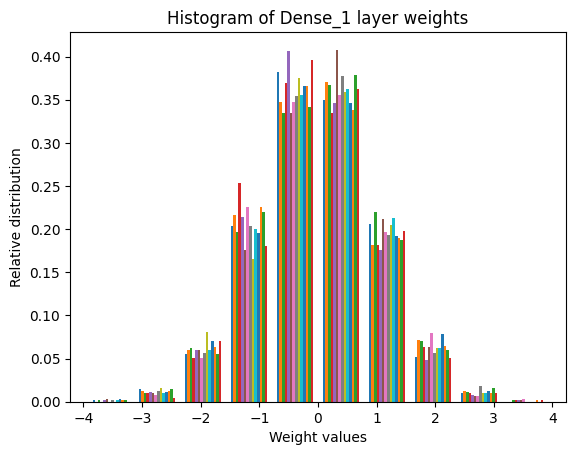

In [23]:
import utils
utils.plot_histogram(dense_1.layer_name, dense_1.weights)

In [24]:
28*28

784

### Model

In [25]:
from activations import Softmax_Categorical_CrossEntropy

In [26]:
dense_1 = DenseLayer("Dense_1", 784, 14)
relu_1 = ReluLayer("relu_1")
dense_2 = DenseLayer("Dense_2", 14, 10)

softmax_loss = Softmax_Categorical_CrossEntropy("Softmax_CCE_1")

In [340]:
y = dense_1.forward(img1.reshape(1, 28, 28))
relu_y = relu_1.forward(y)
y = dense_2.forward(relu_y)

true_labels = y_train[0].reshape(1,1)
loss = softmax_loss.forward(y, true_labels)
print(f"loss {loss}, ypredicted {y}")

# gradients /= samples

global_grad = softmax_loss.backward(softmax_loss.cached_output, true_labels)
print(global_grad.shape)

global_grad = dense_2.backward(global_grad, 1e-6)
print(global_grad.shape)
global_grad = relu_1.backward(global_grad, 1e-6)


loss [[16.11809565]], ypredicted [[ 1212.10167608 -4452.17893816 -3279.38222992  6058.23590186
  -2703.8253442   4036.29283364  6565.74291801 -7483.58342666
   -609.16505943  9183.59830442]]
(1, 10)
(1, 14)


In [ ]:
global_grad = dense_1.backward(global_grad, 1e-06)

In [341]:
relu_y

array([[1215.48713053,    0.        , 2780.3713942 , 1405.36635969,
        3073.09237029,    0.        ,  506.11097248,    0.        ,
         279.45999496, 1412.14358177,    0.        , 1315.95382637,
        1387.30896807,    0.        ]])

In [342]:
relu_y <= 0

array([[False,  True, False, False, False,  True, False,  True, False,
        False,  True, False, False,  True]])

In [344]:
# global_grad[relu_y <= 0] = 0

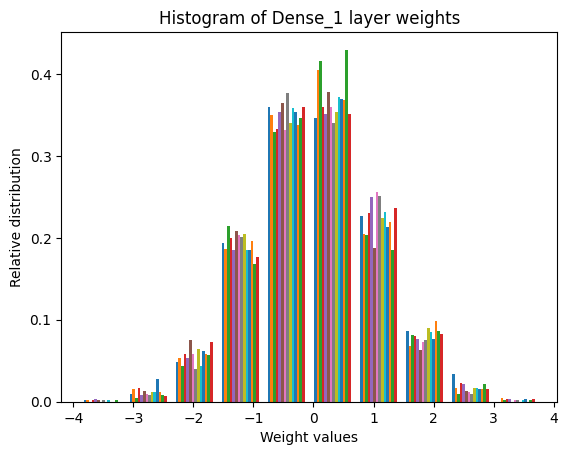

In [346]:
utils.plot_histogram("Dense_1", dense_1.weights)

### Sequential

In [781]:
from model import Sequential

np.random.seed(42)

dense_1 = DenseLayer("Dense_1", 784, 14, debug=False)
relu_1 = ReluLayer("relu_1")
dense_2 = DenseLayer("Dense_2", 14, 10)

layers = [dense_1, relu_1, dense_2]
sequential_model = Sequential(layers)

In [776]:
x_train.shape

(60000, 784)

In [777]:
x_preprocessed = x_train[:4000]
y_preprocessed = y_train[:4000]

x_preprocessed = utils.minmax_normalize(x_preprocessed)

In [778]:
x_val_preprocessed = x_train[4000: 6000]
y_val_preprocessed = y_train[4000: 6000]

x_val_preprocessed = utils.minmax_normalize(x_val_preprocessed)

In [779]:
y_val_preprocessed

array([7, 3, 0, ..., 8, 6, 9], dtype=uint8)

In [780]:
sequential_model.train([x_preprocessed, y_preprocessed], [x_val_preprocessed, y_val_preprocessed], 20, 1, True)

Cached output [[ -5.98731339  -5.09615318   8.63804012 -11.89927197 -12.78085256
   17.87705789  -8.52159543 -12.38684044   4.70789821 -11.30076688
   -0.8606561  -15.10385812  -8.31897927  -4.8203942 ]], ip shape (1, 784), op shape (1, 14)
weights shape (784, 14), weight grad shape (784, 14), input_shape (1, 784), input_grad shape (1, 784), 
Cached output [[-10.41516715   9.14577987  10.6787404   -1.93785104   0.16495781
   -5.10995586  -2.08591725 -10.91966734   1.7732377   -6.62423256
    7.84490473  -5.55173316 -20.42032975   4.09101946]], ip shape (1, 784), op shape (1, 14)
weights shape (784, 14), weight grad shape (784, 14), input_shape (1, 784), input_grad shape (1, 784), 
Cached output [[-12.70116992   4.15878199   7.2630205  -14.96201298 -13.79656973
  -11.46074778   5.16975488  -0.69356798   1.75644569 -16.69535559
   -1.06467911  -2.7443617  -16.58685204  -0.38335704]], ip shape (1, 784), op shape (1, 14)
weights shape (784, 14), weight grad shape (784, 14), input_shape (1,

KeyboardInterrupt: 

In [31]:
x_test_preprocessed = x_test
y_test_preprocessed = y_test

x_test_preprocessed = utils.minmax_normalize(x_test_preprocessed)

In [354]:
sequential_model.test([x_test_preprocessed, y_test_preprocessed])

(81.42, array([0.73575979]))

In [356]:
x_train.shape

(60000, 784)

In [32]:
permuted_idx = np.random.permutation(range(x_train.shape[0]))
x_permuted = x_train[permuted_idx]
y_permuted = y_train[permuted_idx]

2

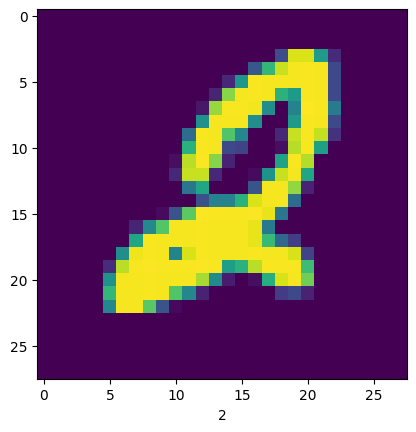

In [363]:
idx = np.random.randint(0,10000)
test_image = utils.minmax_normalize(x_permuted[idx])

plt.imshow(test_image.reshape(28, 28))
plt.xlabel(y_permuted[idx])

np.argmax(sequential_model._forward(np.expand_dims(test_image, 0)))

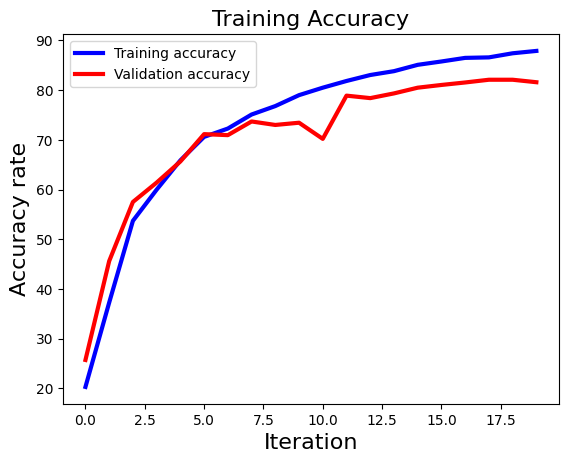

In [364]:
utils.plot_accuracy_curve(sequential_model.train_accuracy, sequential_model.validation_accuracy)

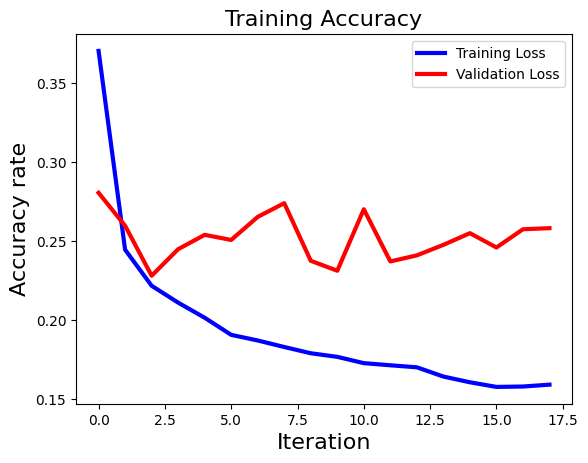

In [329]:
utils.plot_loss_curve(sequential_model.train_loss, sequential_model.validation_loss)

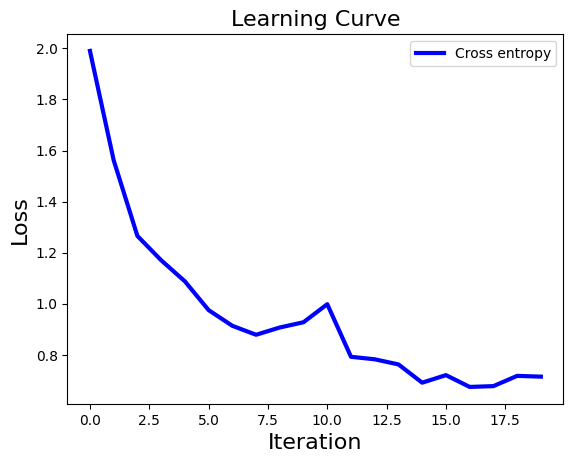

In [365]:
utils.plot_learning_curve(sequential_model.validation_loss)

# Conv layer

In [33]:
import numpy as np
from layer import Layer

In [854]:
class ConvLayer(Layer):
    def __init__(self, layer_name, n_filters = 8, filter_size = 3, stride = 1, debug = True):
        super().__init__(layer_name)
        np.random.seed(42)
                
        self.filter_size = filter_size
        self.stride = stride
        self.n_filters = n_filters

        self.cached_input = None
        self.debug = debug
        self.cached_input_activations = None
        self.cached_output_activations = None

    def get_patch(self, image, width_idx, height_idx, filter_size):
        return image[:, :, height_idx:height_idx+filter_size, width_idx: width_idx+filter_size]

    def forward(self, input_activations):
        '''
        @param input_activations - output of previous layer, will be of shape
        N x C x H x W 
        Conv forward

        1. Get the patch of the size similar to conv filter
        2. Perform convolution on that patch and store in an numpy array
        3. Do the above for all the filters
        4. Append all the filters output and return it for next layer

        '''
        self.cached_input_activations = input_activations
        first_activation = True
        n_samples, input_channels, input_width, input_height = input_activations.shape

        if self.debug:
            print(f"{n_samples=}, {input_channels=}, {input_width=}, {input_height=}")
            
        self.conv_filter = np.random.randn(self.n_filters, input_channels, self.filter_size, self.filter_size) * 0.1

        output_shape = (int((input_width - self.filter_size) / self.stride)) + 1 
        output_activations = np.zeros([])

        for conv_filter in self.conv_filter:
            filter_output = np.zeros((n_samples, output_shape, output_shape))
            height_idx = 0
            filter_y = 0
            
            while (height_idx + self.filter_size) <= input_height:
                width_idx = 0
                filter_x = 0
                while (width_idx + self.filter_size) <= input_width:
                    patch = self.get_patch(input_activations, width_idx, height_idx, self.filter_size)
                  
                   
                    conv = np.sum(conv_filter * patch, axis=(1,2,3))
                    if first_activation:
                        print(f"{height_idx=}, {width_idx=}, {filter_output.shape=}, {patch.shape=}, {conv.shape=}")

                    
                    filter_output[:, filter_y, filter_x] = conv                    
                    width_idx += self.stride
                    filter_x += 1
                    
                height_idx += self.stride
                filter_y += 1
                # filter_output = filter_output.reshape(output_shape, output_shape)
            
            if first_activation:
                output_activations = filter_output
                output_activations = np.expand_dims(output_activations, axis=1)
                first_activation = False

            else:
                filter_output = np.expand_dims(filter_output, axis=1)
                print(f"{output_activations.shape=}, {filter_output.shape=}")
                output_activations = np.append(output_activations, filter_output, axis=1)

            if self.debug:
                print(f"{output_activations.shape=}, {filter_output.shape=}")

        self.cached_output_activations = output_activations
        return output_activations

    def backward(self):
        pass

In [855]:
t = np.random.randn(2, 3, 3, 3)

In [856]:
t = np.array([
    [
        [
            [1,2,3], [1,2,3]
            ],
            [
            [1,2,3], [1,2,3]
            ]
        ], 
    [
        [
            [1,2,3], [1,2,3]
            ],
            [
            [1,2,3], [1,2,3]
            ]
        ]
             ])

print(t.shape)

(2, 2, 2, 3)


In [857]:
s = t.sum(axis=(1,2,3))

In [858]:
s.shape

(2,)

In [859]:
t

array([[[[1, 2, 3],
         [1, 2, 3]],

        [[1, 2, 3],
         [1, 2, 3]]],


       [[[1, 2, 3],
         [1, 2, 3]],

        [[1, 2, 3],
         [1, 2, 3]]]])

In [860]:
s

array([24, 24])

In [861]:
img1.shape

(1, 1, 28, 28)

In [862]:
conv_1 = ConvLayer("conv_1", n_filters = 8, filter_size = 3, stride = 3)

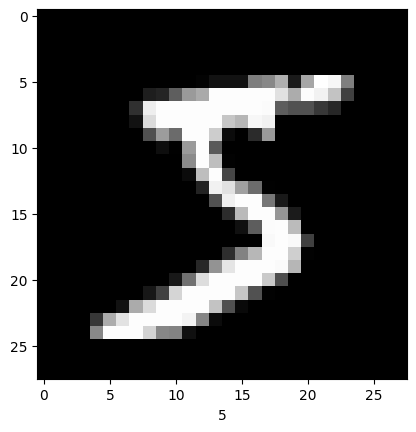

In [863]:
import matplotlib.pyplot as plt

img1 = x_train[0,:].reshape(28,28) # First image in the training set.
plt.imshow(img1,cmap='gray')
plt.xlabel(y_train[0])
plt.show() # Show the image

In [864]:
img1 = np.expand_dims(img1, axis=0)
img1 = np.expand_dims(img1, axis=0)

In [865]:
img1.shape

(1, 1, 28, 28)

In [866]:
conv1_activations = conv_1.forward(img1)

conv1_activations.shape

n_samples=1, input_channels=1, input_width=28, input_height=28
height_idx=0, width_idx=0, filter_output.shape=(1, 9, 9), patch.shape=(1, 1, 3, 3), conv.shape=(1,)
height_idx=0, width_idx=3, filter_output.shape=(1, 9, 9), patch.shape=(1, 1, 3, 3), conv.shape=(1,)
height_idx=0, width_idx=6, filter_output.shape=(1, 9, 9), patch.shape=(1, 1, 3, 3), conv.shape=(1,)
height_idx=0, width_idx=9, filter_output.shape=(1, 9, 9), patch.shape=(1, 1, 3, 3), conv.shape=(1,)
height_idx=0, width_idx=12, filter_output.shape=(1, 9, 9), patch.shape=(1, 1, 3, 3), conv.shape=(1,)
height_idx=0, width_idx=15, filter_output.shape=(1, 9, 9), patch.shape=(1, 1, 3, 3), conv.shape=(1,)
height_idx=0, width_idx=18, filter_output.shape=(1, 9, 9), patch.shape=(1, 1, 3, 3), conv.shape=(1,)
height_idx=0, width_idx=21, filter_output.shape=(1, 9, 9), patch.shape=(1, 1, 3, 3), conv.shape=(1,)
height_idx=0, width_idx=24, filter_output.shape=(1, 9, 9), patch.shape=(1, 1, 3, 3), conv.shape=(1,)
height_idx=3, width_idx=0, filte

(1, 8, 9, 9)

In [867]:
conv1_activations[0].shape

(8, 9, 9)

In [868]:
conv1_activations.shape

(1, 8, 9, 9)

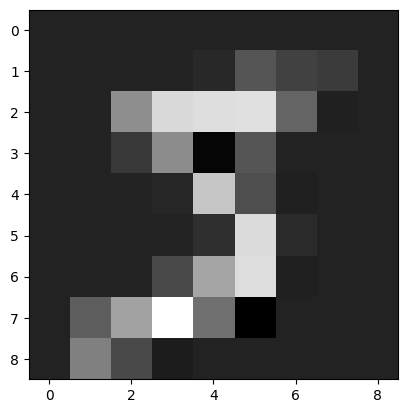

In [869]:
h = conv1_activations.shape[1]
w = conv1_activations.shape[2]
plt.imshow(conv1_activations[0][7], cmap="gray")

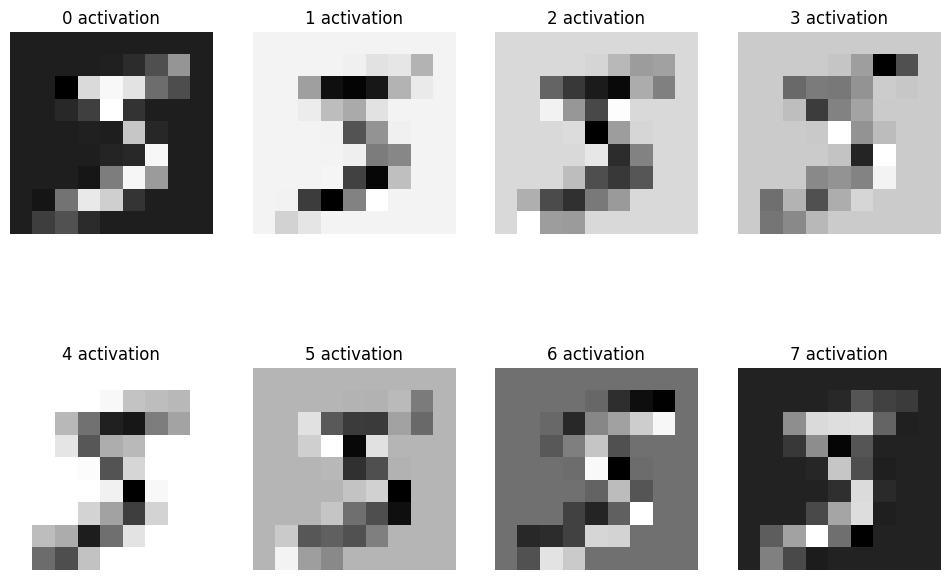

In [873]:
utils.visualize_activations(conv1_activations[0], 2, 4)

# Multiple convolutions

In [874]:
from typing import List

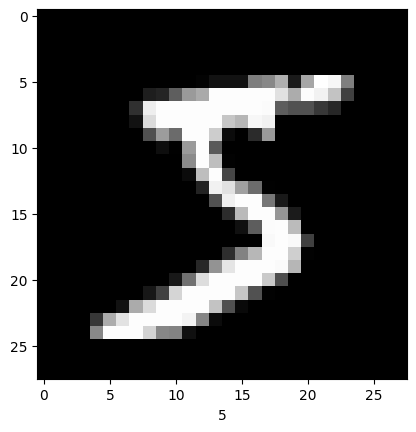

In [878]:
import matplotlib.pyplot as plt

img1 = x_train[0,:].reshape(28,28) # First image in the training set.
plt.imshow(img1,cmap='gray')
plt.xlabel(y_train[0])
plt.show() # Show the image

In [879]:
img1 = np.expand_dims(img1, axis=0)
img1 = np.expand_dims(img1, axis=0)

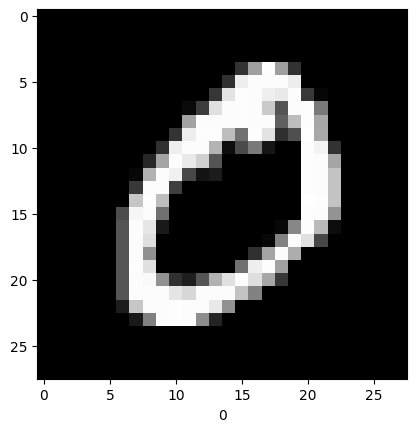

In [880]:
import matplotlib.pyplot as plt

img2 = x_train[1,:].reshape(28,28) # First image in the training set.
plt.imshow(img2,cmap='gray')
plt.xlabel(y_train[1])
plt.show() # Show the image

In [881]:
img2 = np.expand_dims(img2, axis=0)
img2 = np.expand_dims(img2, axis=0)

In [882]:
img1.shape

(1, 1, 28, 28)

In [883]:
img2.shape

(1, 1, 28, 28)

In [884]:
img_data = np.vstack((img1, img2))

print(img_data.shape)

(2, 1, 28, 28)


In [885]:
conv_1 = ConvLayer("conv_1", n_filters = 8, filter_size = 3, stride = 2)
relu_1 = ReluLayer("relu_1")
conv_2 = ConvLayer("conv_2", n_filters = 10, filter_size = 3, stride = 3)
relu_2 = ReluLayer("relu_2")

conv_block: List[Layer] = [conv_1, relu_1, conv_2, relu_2]

output_activations = img_data

for layer in conv_block:
    output_activations = layer.forward(output_activations)

n_samples=2, input_channels=1, input_width=28, input_height=28
height_idx=0, width_idx=0, filter_output.shape=(2, 13, 13), patch.shape=(2, 1, 3, 3), conv.shape=(2,)
height_idx=0, width_idx=2, filter_output.shape=(2, 13, 13), patch.shape=(2, 1, 3, 3), conv.shape=(2,)
height_idx=0, width_idx=4, filter_output.shape=(2, 13, 13), patch.shape=(2, 1, 3, 3), conv.shape=(2,)
height_idx=0, width_idx=6, filter_output.shape=(2, 13, 13), patch.shape=(2, 1, 3, 3), conv.shape=(2,)
height_idx=0, width_idx=8, filter_output.shape=(2, 13, 13), patch.shape=(2, 1, 3, 3), conv.shape=(2,)
height_idx=0, width_idx=10, filter_output.shape=(2, 13, 13), patch.shape=(2, 1, 3, 3), conv.shape=(2,)
height_idx=0, width_idx=12, filter_output.shape=(2, 13, 13), patch.shape=(2, 1, 3, 3), conv.shape=(2,)
height_idx=0, width_idx=14, filter_output.shape=(2, 13, 13), patch.shape=(2, 1, 3, 3), conv.shape=(2,)
height_idx=0, width_idx=16, filter_output.shape=(2, 13, 13), patch.shape=(2, 1, 3, 3), conv.shape=(2,)
height_idx=0, w

In [886]:
conv_1.conv_filter.shape

(8, 1, 3, 3)

In [887]:
conv_2.conv_filter.shape

(10, 8, 3, 3)

# Filter visualization

In [888]:
print(f"{conv_1.conv_filter.shape=}, {conv_2.conv_filter.shape=}")

conv_1.conv_filter.shape=(8, 1, 3, 3), conv_2.conv_filter.shape=(10, 8, 3, 3)


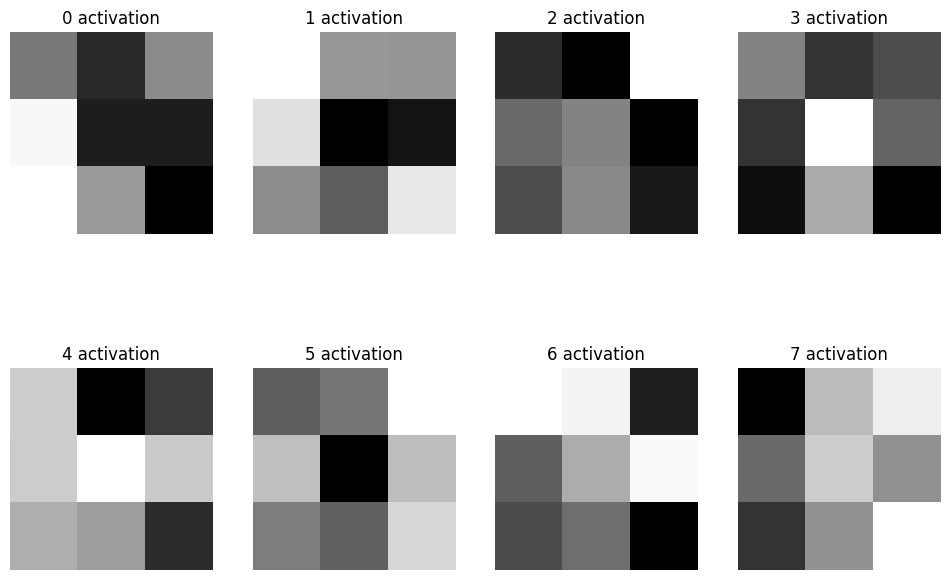

In [889]:
utils.visualize_filters(conv_1.conv_filter, 2, 4)

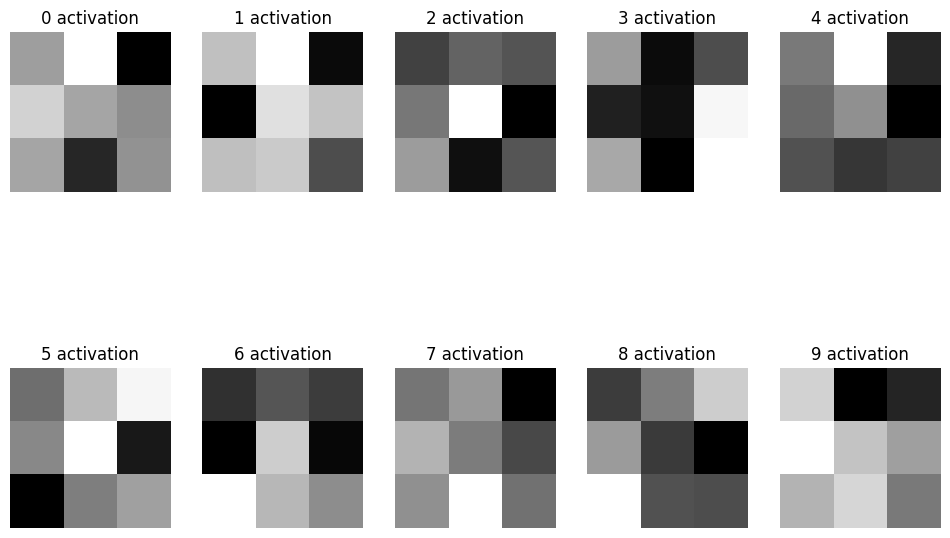

In [890]:
utils.visualize_filters(conv_2.conv_filter, 2, 5)

In [757]:
# def visualize_activations(images, rows, cols):
#     fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
#     for i, ax in enumerate(axes.flat):
#         img = images[i]
#         ax.imshow(img, cmap="gray")
#         ax.set_title(f"{i} activation")
#         ax.axis("off")
#     plt.show()


# Activation visualization

In [891]:
print(f"{conv_1.cached_output_activations.shape=}, {conv_2.cached_output_activations.shape=}")

conv_1.cached_output_activations.shape=(2, 8, 13, 13), conv_2.cached_output_activations.shape=(2, 10, 4, 4)


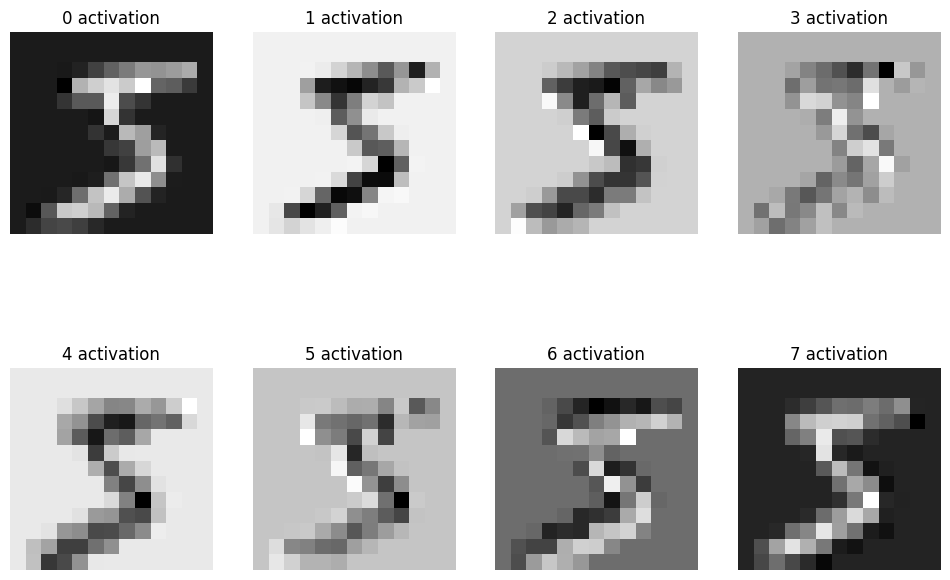

In [892]:
utils.visualize_activations(conv_1.cached_output_activations[0], 2, 4)

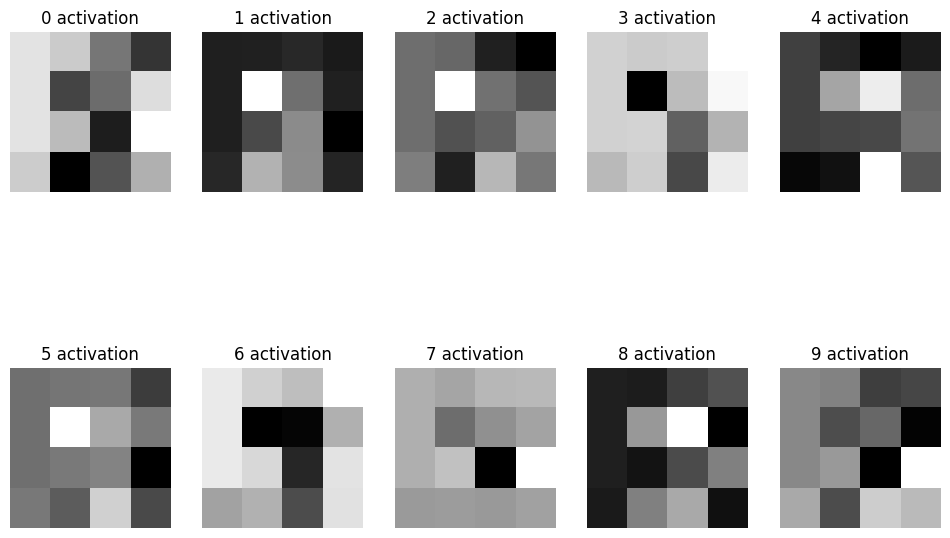

In [893]:
utils.visualize_activations(conv_2.cached_output_activations[0], 2, 5)

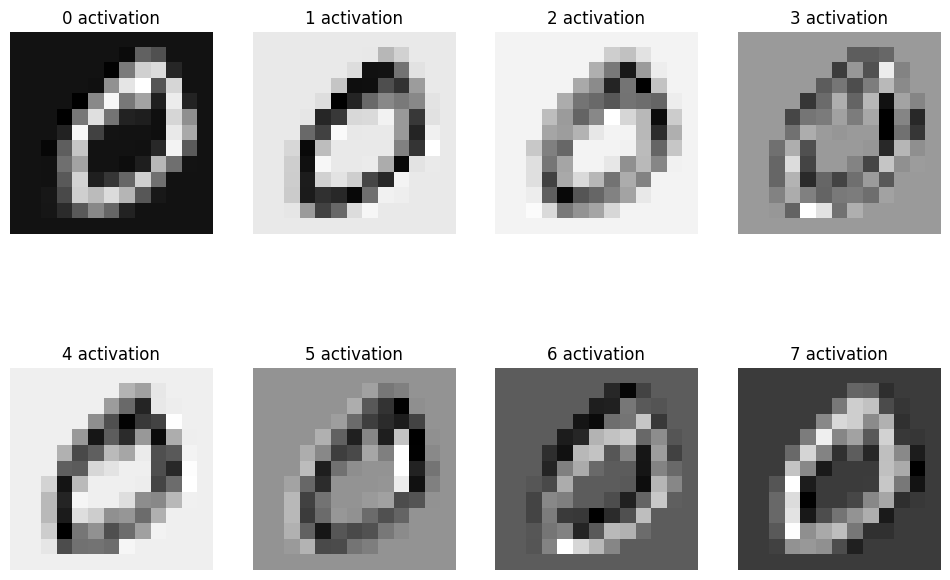

In [894]:
utils.visualize_activations(conv_1.cached_output_activations[1], 2, 4)

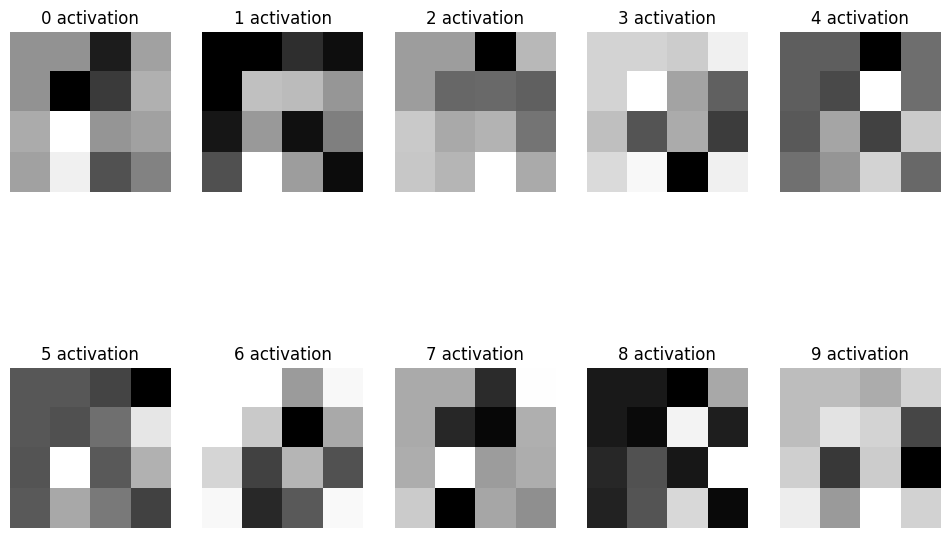

In [895]:
utils.visualize_activations(conv_2.cached_output_activations[1], 2, 5)

# Convolution back prop

In [ ]:
class ConvLayer(Layer):
    def __init__(self, layer_name, n_filters = 8, filter_size = 3, stride = 1, debug = True):
        super().__init__(layer_name)
        np.random.seed(42)
                
        self.filter_size = filter_size
        self.stride = stride
        self.n_filters = n_filters

        self.cached_input = None
        self.debug = debug
        self.cached_input_activations = None
        self.cached_output_activations = None

    def get_patch(self, image, width_idx, height_idx, filter_size):
        return image[:, :, height_idx:height_idx+filter_size, width_idx: width_idx+filter_size]

    def forward(self, input_activations):
        '''
        @param input_activations - output of previous layer, will be of shape
        N x C x H x W 
        Conv forward

        1. Get the patch of the size similar to conv filter
        2. Perform convolution on that patch and store in an numpy array
        3. Do the above for all the filters
        4. Append all the filters output and return it for next layer

        '''
        first_activation = True
        n_samples, input_channels, input_width, input_height = input_activations.shape

        if self.debug:
            print(f"{n_samples=}, {input_channels=}, {input_width=}, {input_height=}")
            
        self.conv_filter = np.random.randn(self.n_filters, input_channels, self.filter_size, self.filter_size) * 0.1

        output_shape = ((input_width - self.filter_size) // self.stride) + 1 
        output_activations = np.zeros([])
        self.cached_input_activations = input_activations

        for conv_filter in self.conv_filter:
            filter_output = np.zeros((n_samples, output_shape, output_shape))
            width_idx, height_idx = 0, 0
            
            while (height_idx + self.filter_size) <= input_height:
                width_idx = 0
                while (width_idx + self.filter_size) <= input_width:
                    patch = self.get_patch(input_activations, width_idx, height_idx, self.filter_size)
                  
                    conv = np.sum(conv_filter * patch, axis=(1,2,3))
                    if first_activation:
                        print(f"{filter_output.shape=}, {patch.shape=}, {conv.shape=}")
                    filter_output[:, height_idx, width_idx] = conv
                    
                    width_idx += 1
                    
                height_idx += 1
            
            if first_activation:
                output_activations = filter_output
                output_activations = np.expand_dims(output_activations, axis=1)
                first_activation = False

            else:
                filter_output = np.expand_dims(filter_output, axis=1)
                print(f"{output_activations.shape=}, {filter_output.shape=}")
                output_activations = np.append(output_activations, filter_output, axis=1)

            if self.debug:
                print(f"{output_activations.shape=}, {filter_output.shape=}")

        self.cached_output_activations = output_activations
        return output_activations

    def backward(self, global_gradients):
        '''
        Backward propagation for the convolutional filters
        '''
        
        